In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import gc
gc.enable()

import warnings

warnings.filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.abspath("../utils"))
import tools

<h1  style= "background-color: gray;
                 color:white;
            text-align: center; 
            font-family:Helvetica, Arial, verdana, sans-serif"> Experiment Tracking </h1>

## 1. Introduction

### Context

In this project, we are going to build a scoring model aims to compute the probability that a customer will repay his loan... 


In [2]:
# run in the terminal : mlflow server --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri("sqlite:///mlflow.db")
 

## Part 1 - EDA & Preprocessing

In this section, we will explore and preprocess data using the tools and technics bellow :
- Produce some visualizations to understand data 
- NaN Imputing with simple imputer
- Reduction of dimension with PCA

**Important :**

We are going to start by loading data. Notice that we processed this using the kernel bellow :

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

Train set: 307511, Test set: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)

 ************************* infos ************************* 

Nombre de colonnes :  799 

Nombre de lignes :  307511 



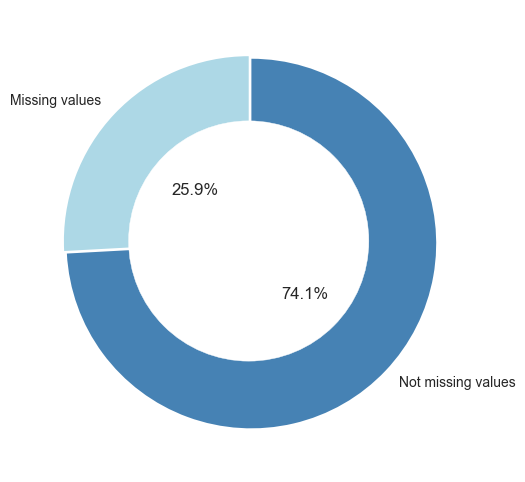

Nombre total de valeurs manquantes :  63544275 



In [4]:
# Load preprocessed data using 
data = tools.main()
# #pickle.dump(data, open('../data/raw_data.pkl', 'wb'))
data_na = data[data['TARGET'].isna()].set_index('SK_ID_CURR')
data = data[data['TARGET'].notnull()].set_index('SK_ID_CURR')
print('\n','*'*25, 'infos', '*'*25,'\n')
tools.describe_data(data)



### Data Exploring

Here are few transformations comes with the kernel used to prepare data...


************************* Anomalies on DAYS_EMPLOYED set to NaN *************************


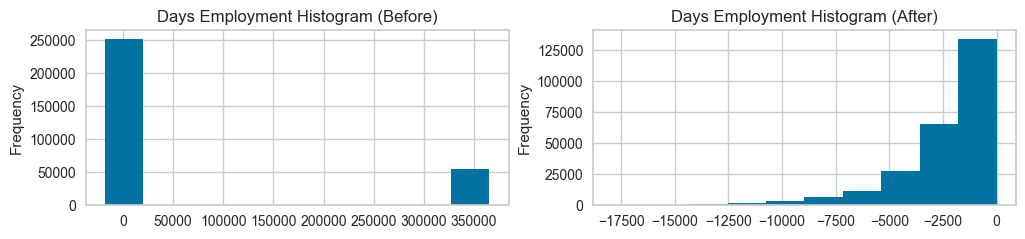

************************* New features are computed *************************


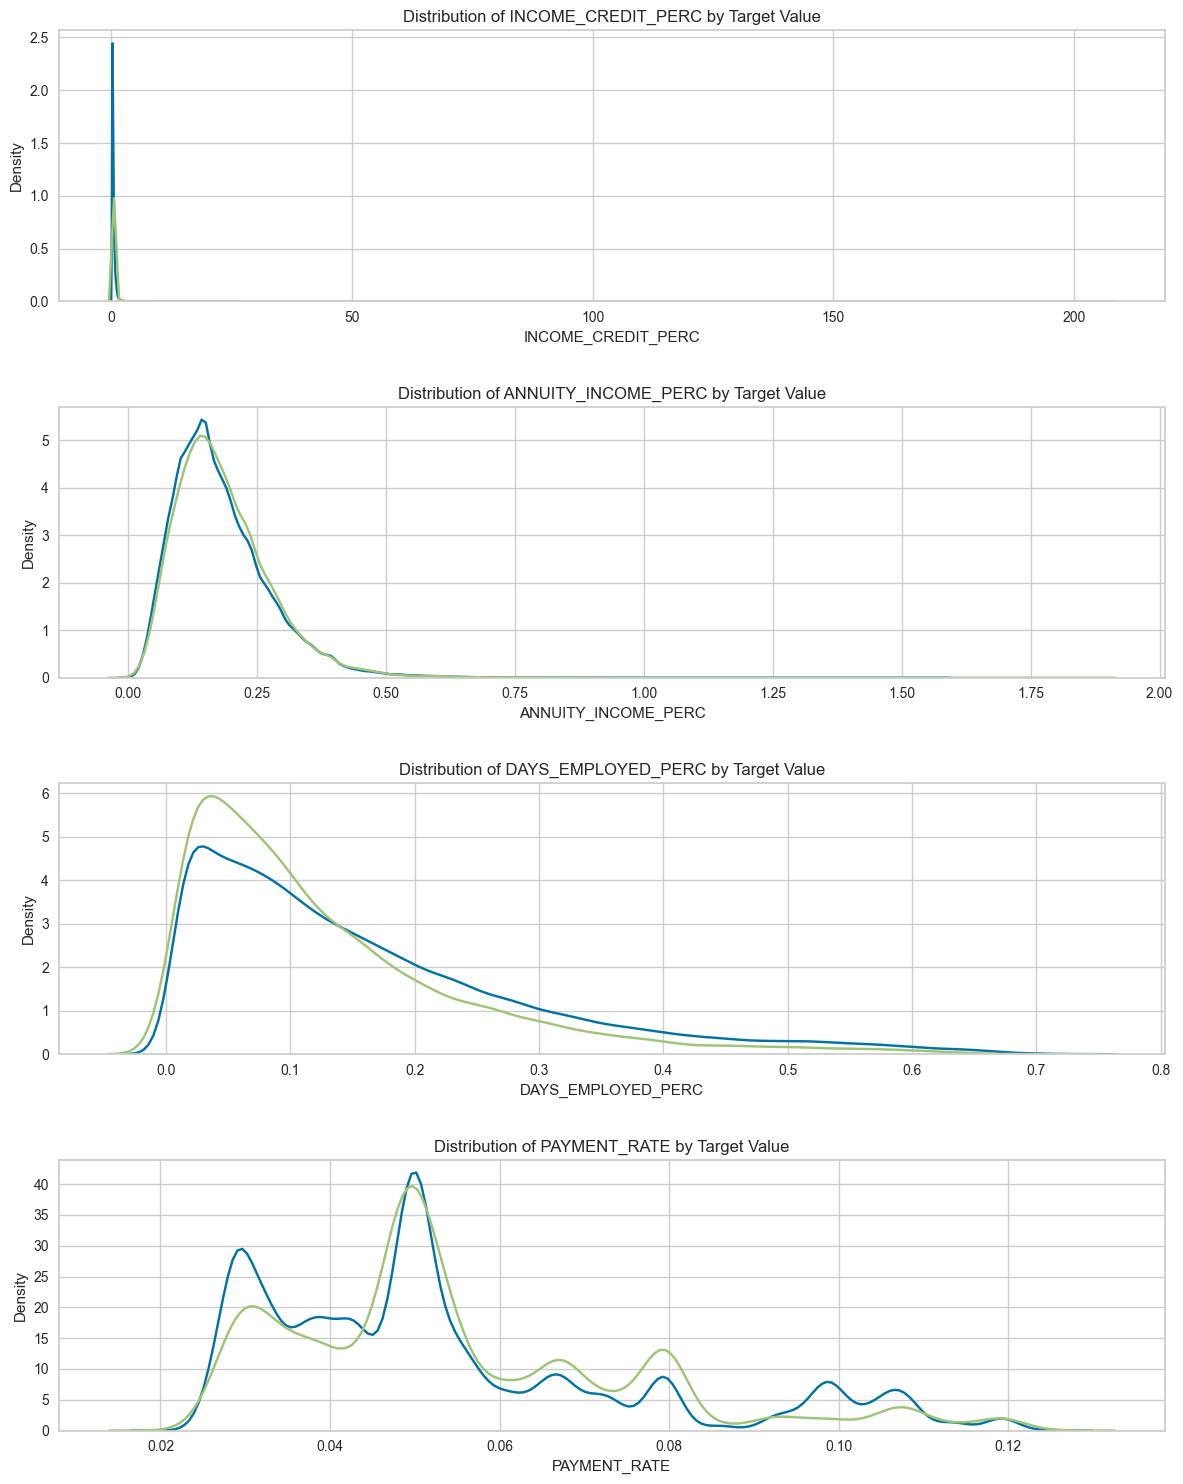

In [5]:
app_train = pd.read_csv('../data_origin/application_train.csv')
print('*'*25, 'Anomalies on DAYS_EMPLOYED set to NaN' , '*'*25)
plt.figure(figsize = (12, 5))
plt.subplot(221)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram (Before)')
plt.subplot(222)
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram (After)')
plt.show()

print('*'*25, 'New features are computed' , '*'*25)

plt.figure(figsize = (12, 15))
# iterate through the new features
for i, feature in enumerate(['INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'DAYS_EMPLOYED_PERC', 'PAYMENT_RATE']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data.loc[data['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data.loc[data['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

We will start by defining **target** and **features**

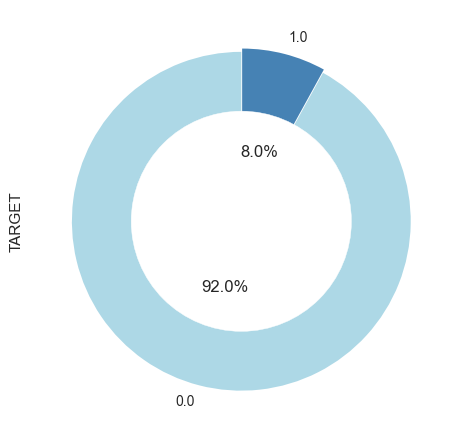

Counter({0.0: 91990, 1.0: 8010})


In [6]:
data_sample = data.sample(100000, random_state=42)
# set the target
y = data_sample['TARGET']


# set features
X = data_sample[[f for f in data.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]]]


# check target
y.value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    explode=(0, 0.02),
    colors=["lightblue", "steelblue"],
    pctdistance=0.4,
    labeldistance=1.1,
)
circle = plt.Circle((0, 0), 0.65, color="white")
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

print(Counter(y))

**Important**

We can see that we are dealing with **imbalanced data** 

In [7]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET']
# correlations = app_train.drop('cashloans', 1).corr()['TARGET']

# Display correlations
print('*'*25,'Top10 positive correlations','*'*25)
display(correlations.sort_values(ascending=False).head(10))
print('*'*25,'Top10 negative correlations','*'*25)
display(correlations.sort_values().head(10))

************************* Top10 positive correlations *************************


TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

************************* Top10 negative correlations *************************


EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

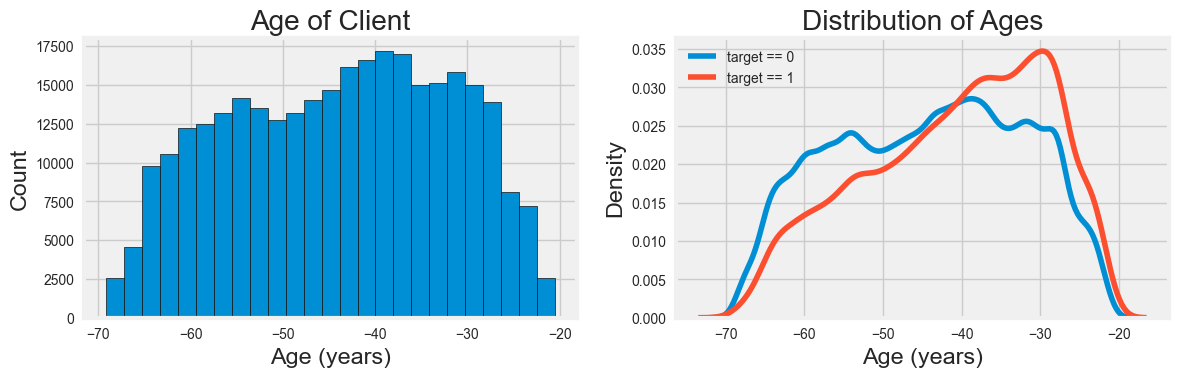

In [8]:
plt.figure(figsize = (14, 8))

# Set the style of plots
plt.style.use('fivethirtyeight')
plt.subplot(221)
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

plt.subplot(222)
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend()
plt.show()

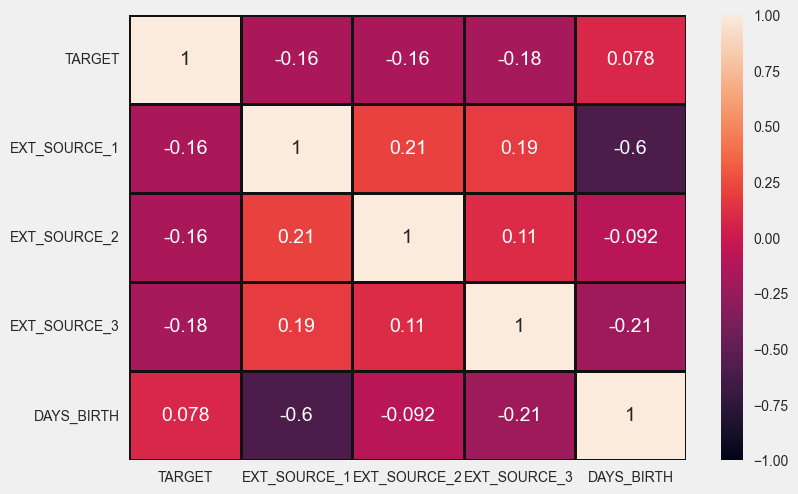

In [9]:
# Extract the EXT_SOURCE variables and show correlations
ext_data_corrs = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()

# Heatmap of correlations
sns.heatmap(ext_data_corrs,  vmin=-1, vmax=1, annot=True, linecolor='k', linewidths=2)
plt.show()

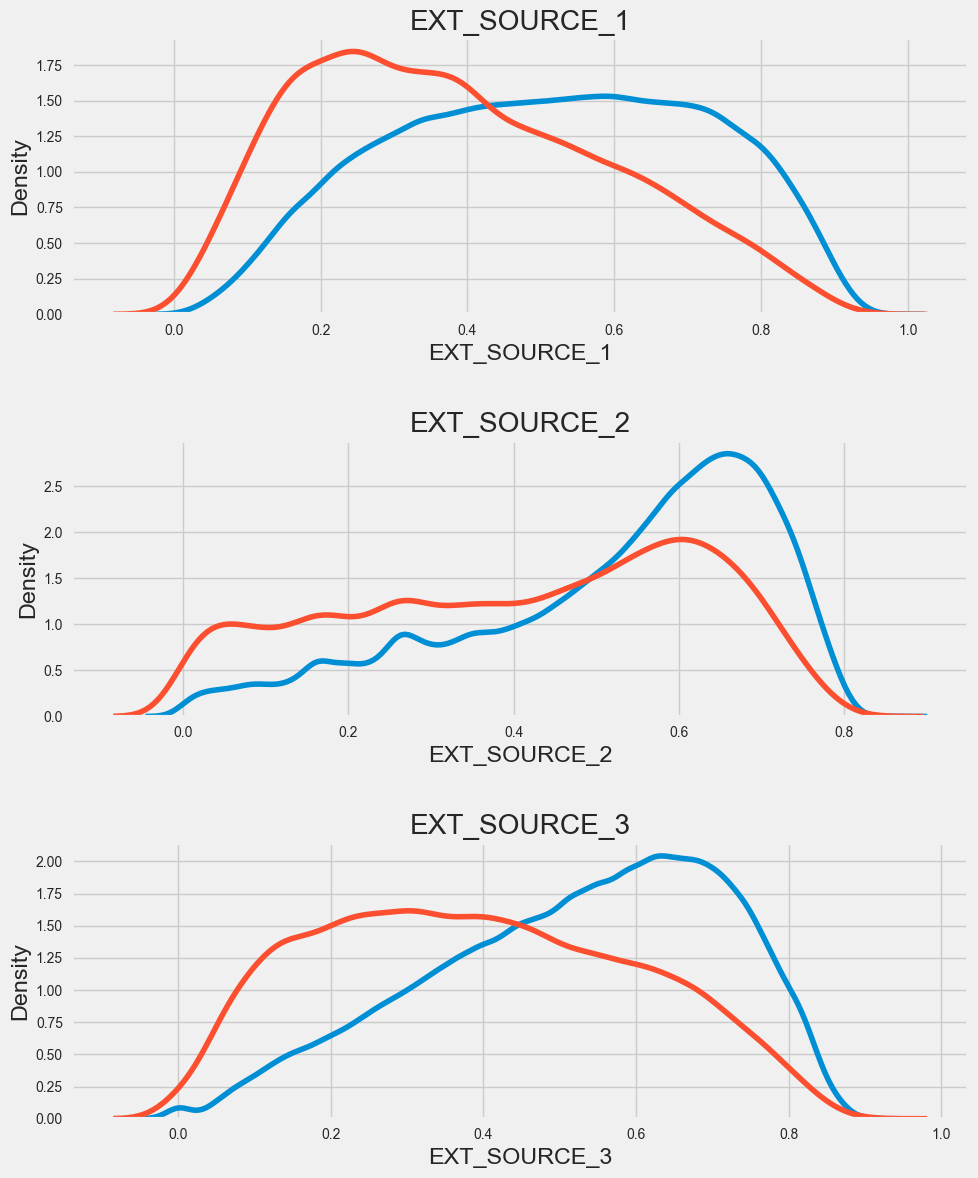

In [10]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('%s' % source)
    #plt.xlabel('%s' % source); plt.ylabel('Density')
    
    plt.tight_layout(h_pad = 2.5)

### NaN Imputing

************************* Describe data *************************


,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,100000.00000,100000.000000,100000.00000,1.000000e+05,1.000000e+05,99996.000000,9.991800e+04,100000.000000,100000.000000,81959.000000,...,28329.000000,28329.000000,28329.000000,28128.000000,28329.0,28329.0,28329.0,28329.0,28128.0,28329.000000
mean,0.33864,0.308400,0.41727,1.695117e+05,5.983198e+05,27099.675522,5.377386e+05,0.020859,-16039.435800,-2383.066912,...,0.049137,0.003608,0.105440,0.002999,0.0,0.0,0.0,0.0,0.0,36.931307
std,0.47325,0.461835,0.72643,3.891570e+05,4.018237e+05,14443.694447,3.688397e+05,0.013822,4371.907969,2333.370072,...,0.216158,0.030596,1.174785,0.019564,0.0,0.0,0.0,0.0,0.0,33.604104
min,0.00000,0.000000,0.00000,2.565000e+04,4.500000e+04,1980.000000,4.500000e+04,0.000290,-25201.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,0.00000,0.000000,0.00000,1.125000e+05,2.700000e+05,16573.500000,2.385000e+05,0.010006,-19681.000000,-3174.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,0.00000,0.000000,0.00000,1.485000e+05,5.123385e+05,24916.500000,4.500000e+05,0.018850,-15739.000000,-1647.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,21.000000
75%,1.00000,1.000000,1.00000,2.025000e+05,8.086500e+05,34587.000000,6.795000e+05,0.028663,-12412.000000,-773.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,75.000000
max,1.00000,1.000000,19.00000,1.170000e+08,4.050000e+06,230161.500000,4.050000e+06,0.072508,-7673.000000,0.000000,...,1.000000,1.000000,61.000000,0.500000,0.0,0.0,0.0,0.0,0.0,192.000000


************************* After imputing NaN *************************
Nombre de colonnes :  797 

Nombre de lignes :  100000 



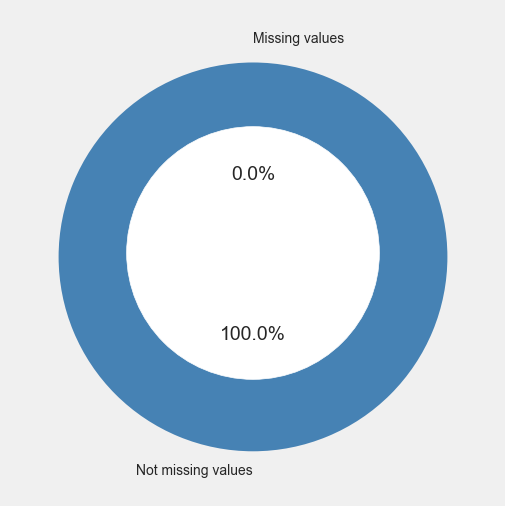

Nombre total de valeurs manquantes :  0 



20770

In [11]:
print('*'*25, 'Describe data', '*'*25)
display(X.describe())

X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X.iloc[:, :] = imputer.fit_transform(X)
print('*'*25, 'After imputing NaN', '*'*25)
tools.describe_data(X)
gc.collect()

### Scale Data

In [12]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,1.0,1.0,0.105263,0.001550,0.104983,0.222021,0.093258,0.129331,0.679142,0.957459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104712
214010,1.0,0.0,0.000000,0.001897,0.308792,0.205830,0.283146,0.090864,0.594649,0.936300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120419
142232,1.0,1.0,0.000000,0.001512,0.112360,0.162719,0.112360,0.491595,0.416134,0.964326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104712
389171,0.0,0.0,0.000000,0.001897,0.052360,0.100617,0.044944,0.635991,0.318063,0.610205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104712
283617,0.0,0.0,0.000000,0.000742,0.065701,0.060840,0.047191,0.257000,0.278069,0.938310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125654


### Feature Selection

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [14]:
# rfc = RandomForestClassifier()

# select = RFECV(estimator=rfc)
# select = select.fit(X_scaled,y)
 
#print("Feature ranking: ", select.ranking_)

### Cross validation and splitting

In [15]:
X_train, X_test, y_train, y_test = tools.cross_val_split(X_scaled_df, y)

X_train shape : (90000, 797)
X_test shape : (10000, 797)
y_train shape : (90000,)
y_test shape : (10000,)


### Resampling

In [16]:
# Under sampling
us = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_under, y_under = us.fit_resample(X_train, y_train)
print("Under sampled dataset shape {}".format(Counter(y_under)))

# Over sampling
os = SMOTE(random_state=42)
X_over, y_over = os.fit_resample(X_train, y_train)
print("Over sampled dataset shape {}".format(Counter(y_over)))



Under sampled dataset shape Counter({0.0: 7204, 1.0: 7204})
Over sampled dataset shape Counter({0.0: 82796, 1.0: 82796})


## Part2 - Modeling

In [17]:
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, auc
from sklearn.model_selection import GridSearchCV


In [18]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method",
                                "AUC", "AUC_test", "Time"])

Here, we will experiment few models using mlflow. 

Experiment tracking is a process used to track all the relevant information from a machine learning experience which includes :
source code, environment, data, model, hyperpamameters and metrics. 
It is important for basicly 3 reaseons : 
- Reproducibility : as datascientist we experiment a lot of models and need to reproduce the ones with the best paarameters...
- Organization : in case  u work in a team and need versioning and organization
- Optimization : automation help us track metrics and parameters and chose the best ones...
<!-- 
In this section we are going to use mlflow in order to experiment 3 classification algorithms such as :
- Logistic regression
- LightGBM
- XGboost
- -->


**Artifact**  =>  [Click here to read more about Artifacts...](https://h2o.ai/wiki/artifacts/)

**Classifiction reppots metrics**  =>  [More about classification report from sklearn](https://www.jcchouinard.com/classification-report-in-scikit-learn/)

### Logistic Regression

2023/04/30 16:17:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/95b665dd916c414fa5824600f506070f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_normal_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      9194
         1.0       0.60      0.04      0.07       806

    accuracy                           0.92     10000
   macro avg       0.76      0.52      0.51     10000
weighted avg       0.90      0.92      0.89     10000



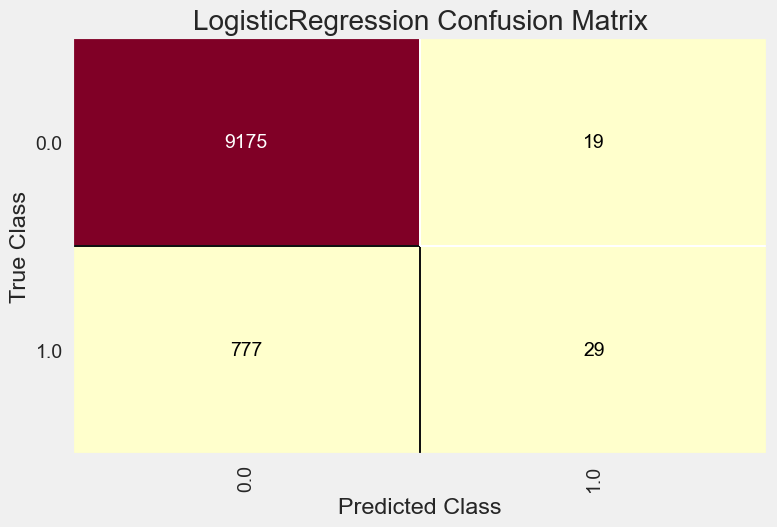

2023/04/30 16:18:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/e07ac6e3c122410ab8e967f5c162a9aa/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_under_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      9194
         1.0       0.17      0.73      0.28       806

    accuracy                           0.70     10000
   macro avg       0.57      0.71      0.54     10000
weighted avg       0.90      0.70      0.76     10000



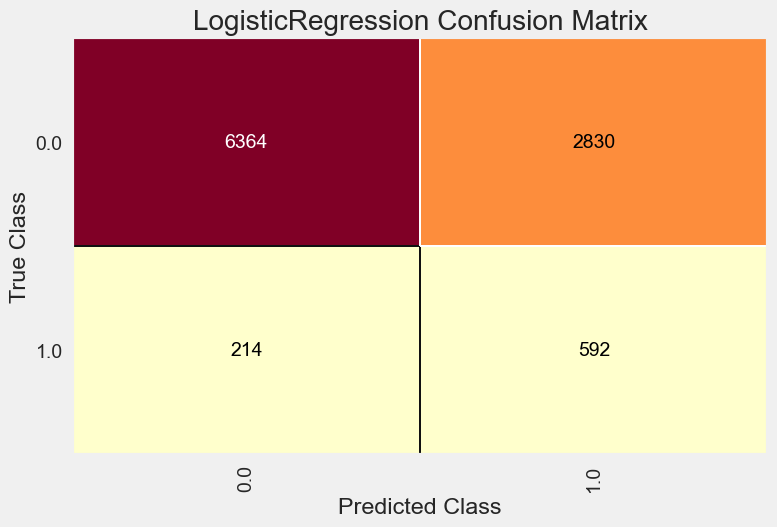

2023/04/30 16:18:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/d253b37df5e848d9b98042452200f237/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      9194
         1.0       0.17      0.67      0.28       806

    accuracy                           0.72     10000
   macro avg       0.57      0.70      0.55     10000
weighted avg       0.90      0.72      0.78     10000



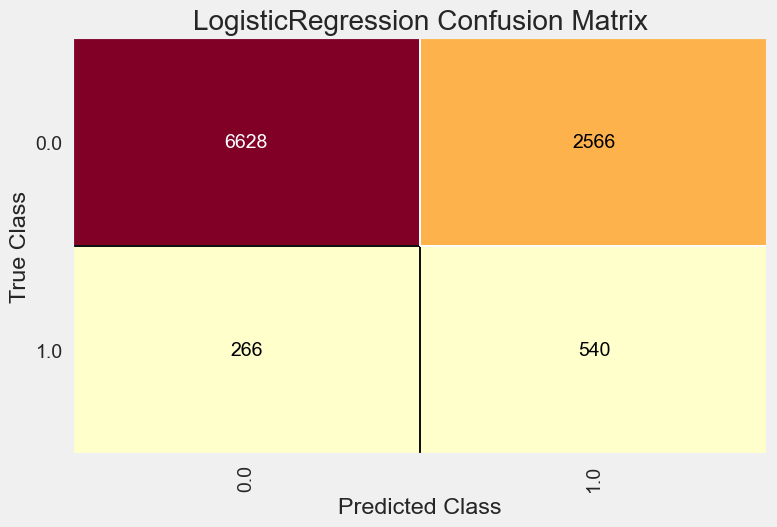

2023/04/30 16:18:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/9d37cbeff3074e07a8e8a5b3c711d524/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      9194
         1.0       0.18      0.72      0.28       806

    accuracy                           0.71     10000
   macro avg       0.57      0.71      0.55     10000
weighted avg       0.90      0.71      0.77     10000



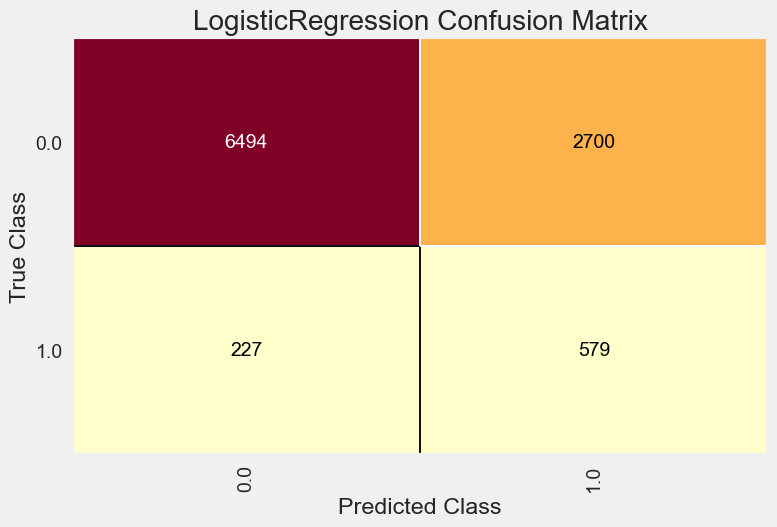

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.774,0.785,9.536743e-07
1,Baseline,Undersampling,0.785,0.788,9.536743e-07
2,Baseline,Oversampling,0.807,0.771,0.000000e+00
3,Baseline,Balanced,0.778,0.787,0.000000e+00


In [19]:
from sklearn.linear_model import LogisticRegression

experiment_name = "logistic_regression"
model_name = LogisticRegression()

# run with normal data
name = "reg_logistic_normal_data"
results.loc[len(results)], reg_log_normal = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'Baseline', 'Original')

# run with under sampled data
name = "reg_logistic_under_sampled_data"
results.loc[len(results)], reg_log_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test,'Baseline', 'Undersampling')

# run with over sampled data
name = "reg_logistic_over_sampled_data"
results.loc[len(results)], reg_log_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test, 'Baseline', 'Oversampling')

#-----------

model_name = LogisticRegression(class_weight="balanced")
results.loc[len(results)], reg_log_balanced  = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'Baseline', 'Balanced')

#-------------

results

#### Tuning

In [20]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")


params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)
gc.collect()

26774

2023/04/30 16:22:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/6c8dc4058543417a8c3ac815022436ea/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:22:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/6c8dc4058543417a8c3ac815022436ea/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:22:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      9194
         1.0       0.70      0.03      0.06       806

    accuracy                           0.92     10000
   macro avg       0.81      0.52      0.51     10000
weighted avg       0.90      0.92      0.89     10000



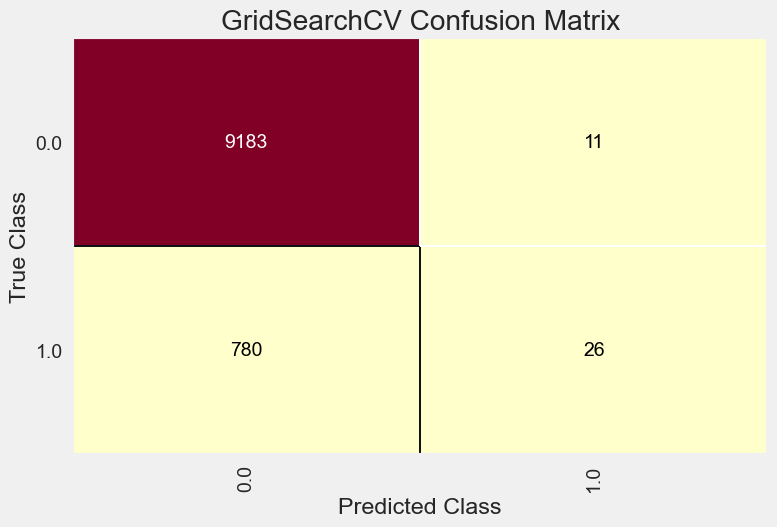

2023/04/30 16:23:16 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/aff47111478b4a37984747ecade04ecd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:23:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/aff47111478b4a37984747ecade04ecd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:23:19 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      9194
         1.0       0.17      0.73      0.28       806

    accuracy                           0.69     10000
   macro avg       0.57      0.71      0.54     10000
weighted avg       0.90      0.69      0.76     10000



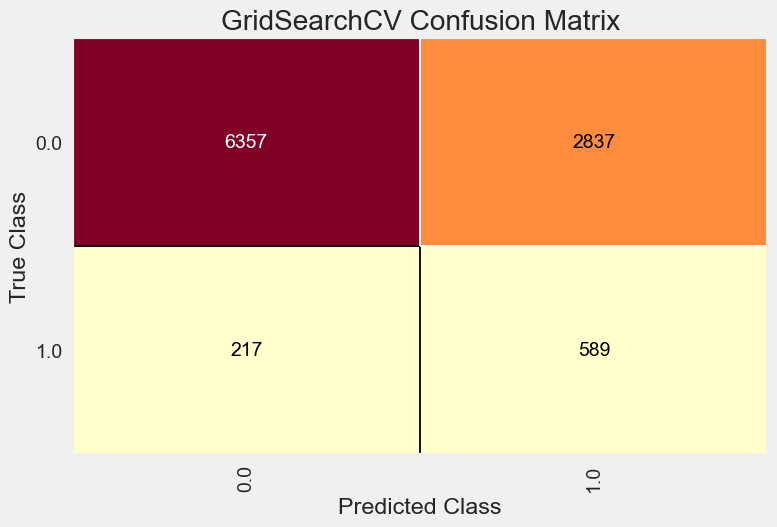

2023/04/30 16:28:24 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/80435eded3cb4f3ba4d8cb2d4737bcc5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:28:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/80435eded3cb4f3ba4d8cb2d4737bcc5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:28:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      9194
         1.0       0.17      0.67      0.27       806

    accuracy                           0.71     10000
   macro avg       0.57      0.69      0.55     10000
weighted avg       0.90      0.71      0.78     10000



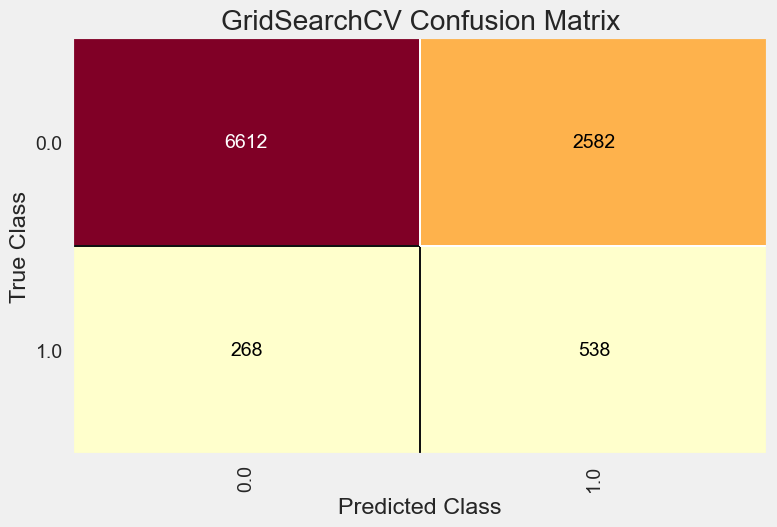

2023/04/30 16:31:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/0a00b9cdd07e49db989c33af012af891/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:31:52 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/0a00b9cdd07e49db989c33af012af891/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:31:52 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81      9194
         1.0       0.18      0.72      0.28       806

    accuracy                           0.71     10000
   macro avg       0.57      0.71      0.55     10000
weighted avg       0.90      0.71      0.77     10000



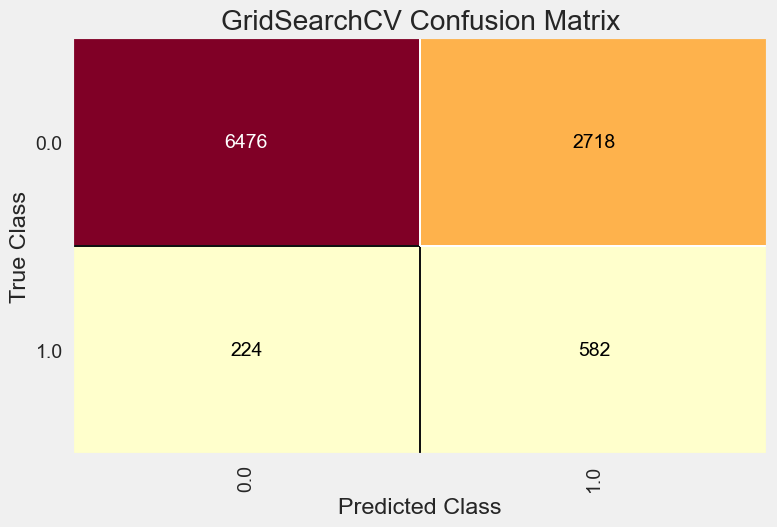

In [21]:
model_name = gs_lr
experiment_name = 'Tuned_LogisticRegression'
results.loc[len(results)], tuned_reg_log_normal  = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'LogisticRegression', 'Original')
results.loc[len(results)], tuned_reg_log_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test,'LogisticRegression', 'Undersampling')
results.loc[len(results)], tuned_reg_log_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test,'LogisticRegression', 'Oversampling')

#---------
model_name = gs_lr_balanced
results.loc[len(results)], tuned_reg_log_balanced = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'LogisticRegression', 'Balanced')


In [22]:
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.774,0.785,9.536743e-07
1,Baseline,Undersampling,0.785,0.788,9.536743e-07
2,Baseline,Oversampling,0.807,0.771,0.000000e+00
3,Baseline,Balanced,0.778,0.787,0.000000e+00
4,LogisticRegression,Original,0.760,0.787,0.000000e+00
5,LogisticRegression,Undersampling,0.759,0.787,0.000000e+00
6,LogisticRegression,Oversampling,0.806,0.770,1.192093e-06
7,LogisticRegression,Balanced,0.761,0.789,0.000000e+00


### LightGBM 

In [23]:
from lightgbm import LGBMClassifier


In [24]:
lgbm = LGBMClassifier(random_state = 42, objective = 'binary')

lgbm_balanced = LGBMClassifier(random_state = 42,
                                   objective = 'binary',
                                   class_weight = 'balanced')

params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

2023/04/30 16:34:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/802d628d509e43ca85fdc682c3803059/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:34:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/802d628d509e43ca85fdc682c3803059/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:34:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


************************* Test scores - lightGBM_normal_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      9194
         1.0       0.58      0.04      0.07       806

    accuracy                           0.92     10000
   macro avg       0.75      0.52      0.51     10000
weighted avg       0.89      0.92      0.89     10000



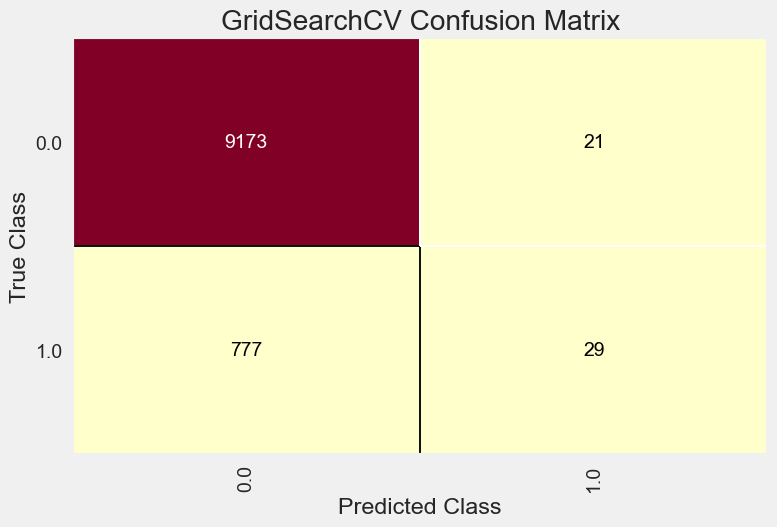

2023/04/30 16:36:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/f23be3f3ed1744d3a6679ad242be8ecf/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:36:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/f23be3f3ed1744d3a6679ad242be8ecf/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:36:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


************************* Test scores - lightGBM_under_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      9194
         1.0       0.17      0.73      0.28       806

    accuracy                           0.70     10000
   macro avg       0.57      0.71      0.54     10000
weighted avg       0.90      0.70      0.77     10000



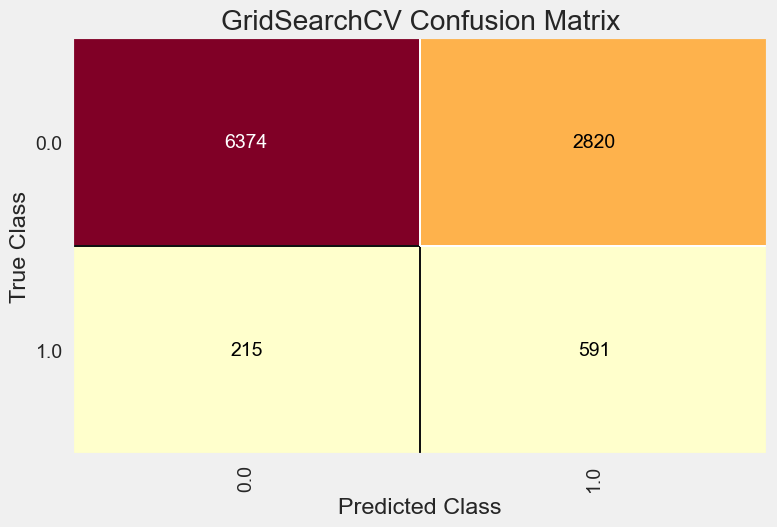

2023/04/30 16:43:25 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/30be61f72c3d4c62a3a014617d898a4f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:43:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/30be61f72c3d4c62a3a014617d898a4f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:43:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


************************* Test scores - lightGBM_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      9194
         1.0       0.48      0.03      0.06       806

    accuracy                           0.92     10000
   macro avg       0.70      0.51      0.51     10000
weighted avg       0.89      0.92      0.89     10000



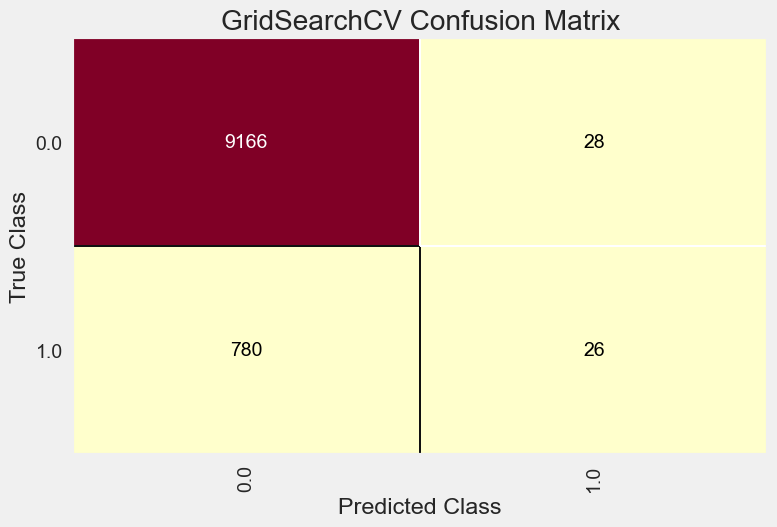

2023/04/30 16:47:01 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/8affcfb3fc4b447a87a78c6126d929c7/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:47:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/8affcfb3fc4b447a87a78c6126d929c7/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/30 16:47:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


************************* Test scores - lightGBM_balanced *************************
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      9194
         1.0       0.20      0.70      0.31       806

    accuracy                           0.75     10000
   macro avg       0.58      0.73      0.58     10000
weighted avg       0.90      0.75      0.81     10000



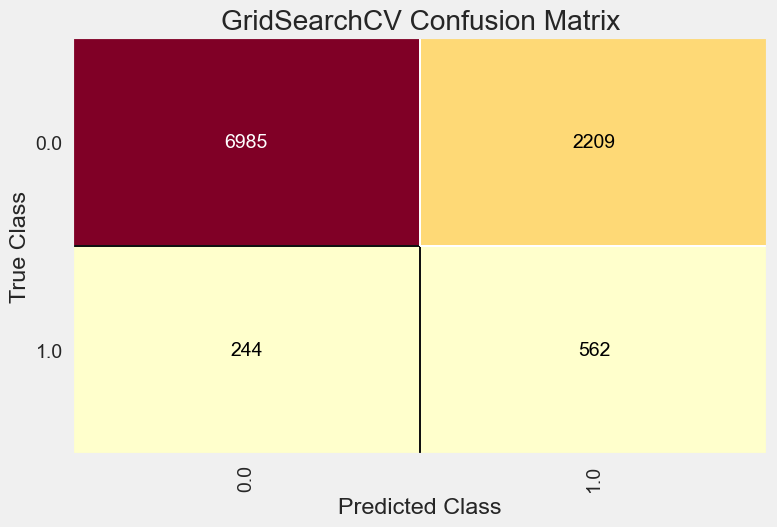

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.774,0.785,9.536743e-07
1,Baseline,Undersampling,0.785,0.788,9.536743e-07
2,Baseline,Oversampling,0.807,0.771,0.000000e+00
3,Baseline,Balanced,0.778,0.787,0.000000e+00
4,LogisticRegression,Original,0.760,0.787,0.000000e+00
5,LogisticRegression,Undersampling,0.759,0.787,0.000000e+00
6,LogisticRegression,Oversampling,0.806,0.770,1.192093e-06
7,LogisticRegression,Balanced,0.761,0.789,0.000000e+00
8,lightGBM,Normal_data,0.769,0.797,0.000000e+00
9,lightGBM,Undersampling,0.766,0.796,2.145767e-06


In [25]:
experiment_name = "lightGBM"
model_name = gs_lgbm

# run with normal data
name = "lightGBM_normal_data"
results.loc[len(results)], lgbm_normal = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test, 'lightGBM', 'Normal_data')

# run with undersampled data
name = "lightGBM_under_sampled_data"
results.loc[len(results)], lgbm_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test, 'lightGBM', 'Undersampling')

# run with oversampled data
name = "lightGBM_over_sampled_data"
results.loc[len(results)], lgbm_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test, 'lightGBM', 'Oversampling')

model_name = gs_lgbm_balanced
name = "lightGBM_balanced"
results.loc[len(results)], lgbm_balanced = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test, 'lightGBM', 'Balanced')

results

### Custom score


In [26]:
from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [27]:
def custom_score(y_true, y_pred) :
    '''
        This function aims to minimize the risk for a given loan.
    
        Parameters
        --------
        - y_true : true values of the target
        - y_pred : predicted value for the target
            
        Returns
        --------
        - score : score for the prediction
    '''

    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    total_neg = TN + FP    # total negatives cases
    total_pos = TP + FN    # total positives cases
    
   
    
    dangerous_situation = -10   # The loan is granted but the customer defaults : the bank loses money 
    nice_situation = 1      # The loan is refunded => the bank makes money
    nulle_situation = 0     # The loan is (rightly) refused : the bank neither wins nor loses money
    no_good_situation = -1    # Loan is refused by mistake : the bank loses money it could have made, 
    

    # total gains
    gain = TP*nulle_situation + TN*nice_situation + FP*no_good_situation + FN*dangerous_situation
    
    # if all observations are correctly predicted
    best = total_neg*nice_situation + total_pos*nulle_situation 

    # if all observations are predicted = 0
    baseline = total_neg*nice_situation + total_pos*dangerous_situation 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score

In [28]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

In [29]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [30]:

%%time
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|██████████| 10/10 [07:04<00:00, 42.44s/trial, best loss: 0.9771515824541921]
CPU times: user 19min 39s, sys: 2min 23s, total: 22min 2s
Wall time: 7min 4s


In [31]:
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
signature = infer_signature(X_train, y_train)

In [32]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    class_weight = 'balanced',)

lgbm.fit(X_train, y_train)

2023/04/30 16:54:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1a1bed12f2e640c7939996f0e959923e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2023/04/30 16:54:35 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/1a1bed12f2e640c7939996f0e959923e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


CPU times: user 53.9 s, sys: 5.62 s, total: 59.6 s
Wall time: 23.4 s


LGBMClassifier(class_weight='balanced', colsample_bytree=0.6138809437407684,
               learning_rate=0.028396371856074947, max_depth=5,
               n_estimators=600, reg_lambda=15.290875161984811,
               subsample=0.8348717776986684)

In [33]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.799082


In [34]:
pickle.dump(lgbm, open("../app/models/best_model.pkl", "wb"))

In [35]:
#Sauvegarde du modèle
tt = pickle.load(open("../app/models/best_model.pkl", "rb"))

### Explainability

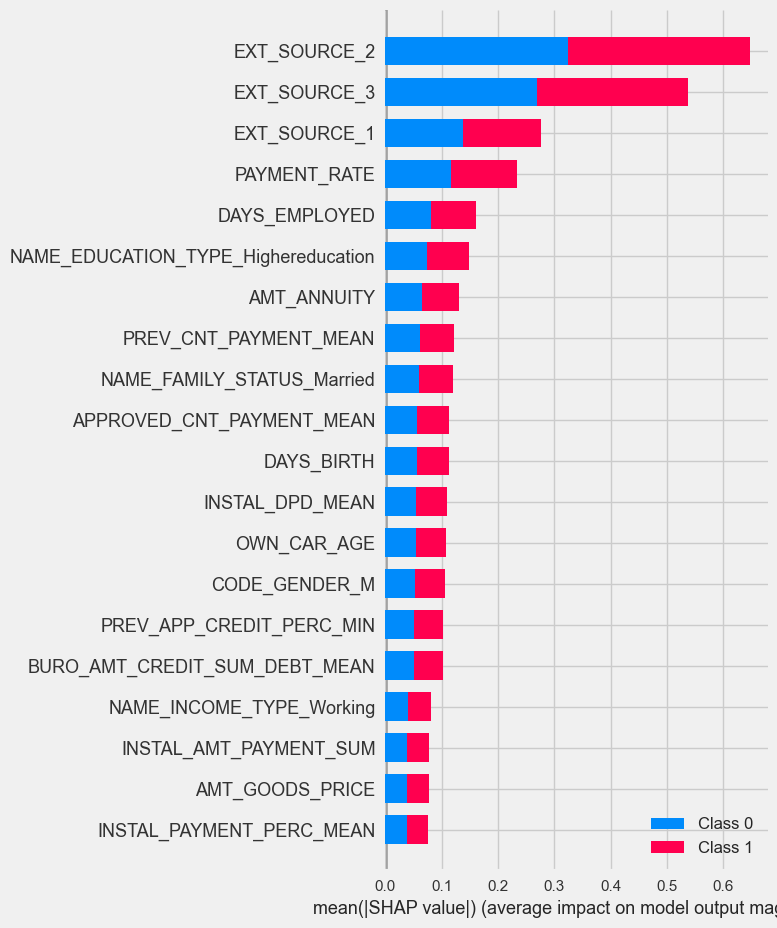

In [36]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)


# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

In [37]:
%time 
shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


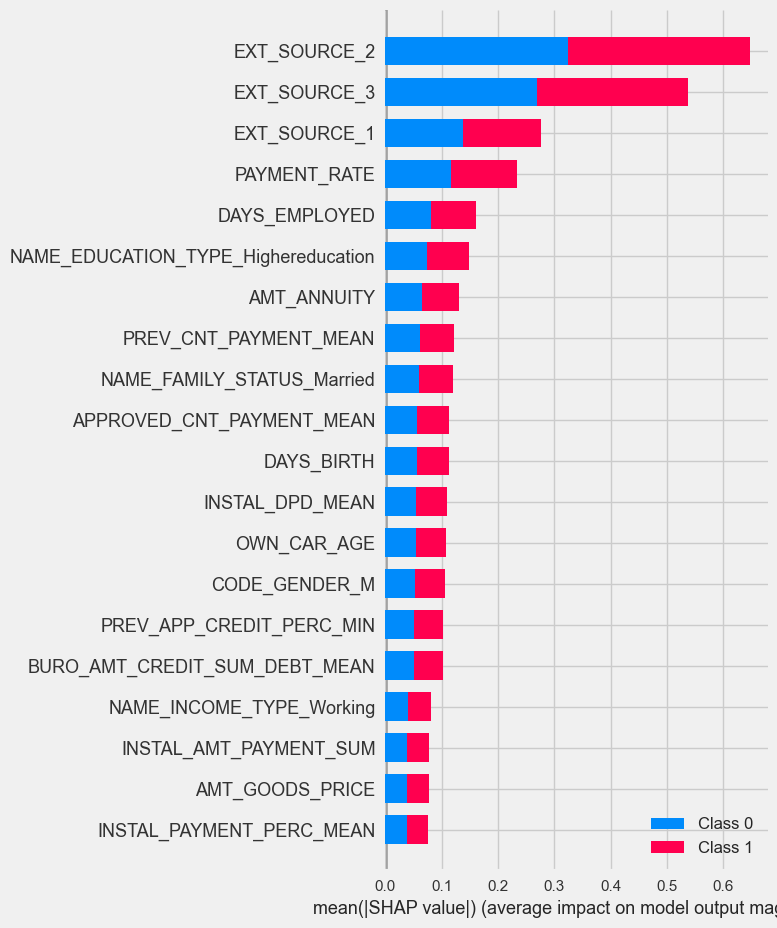

In [38]:
shap.summary_plot(shap_values, X_test)

100%|===================| 89931/90000 [16:58<00:00]        

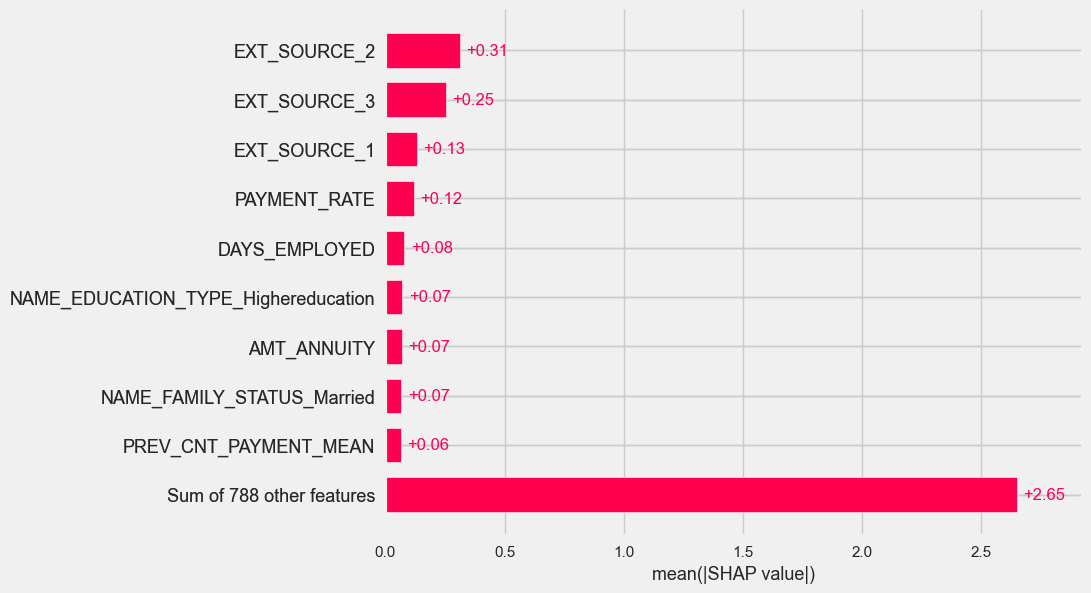

In [39]:
# compute SHAP values

explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

### Prepare data for dashboard

In [47]:
app_train  = pd.read_csv('/Users/alhassanneahmedap59_cb/git/loan-scoring/data_origin/application_train.csv')
app_test = pd.read_csv('/Users/alhassanneahmedap59_cb/git/loan-scoring/data_origin/application_test.csv')
raw_data = pd.concat([app_train, app_test]).sort_values('SK_ID_CURR')

full_data = pd.concat([data,data_na]).reset_index().sort_values('SK_ID_CURR').set_index('SK_ID_CURR')

full_data = full_data[full_data.index <=110000]
full_data


,index,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,NaN,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,0,1.0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,1,0.0,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,2,0.0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,1,NaN,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109996,8585,0.0,0,0,0,180000.0,101880.0,10206.0,90000.0,0.019101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
109997,8586,0.0,0,0,0,157500.0,139500.0,5386.5,139500.0,0.026392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0
109998,8587,0.0,0,0,0,49500.0,536917.5,19413.0,463500.0,0.006207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
full_data.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(missing_values=np.nan, strategy="median")
full_data.iloc[:, :] = imputer.fit_transform(full_data)

full_data = full_data[[f for f in data.columns if f not in ["TARGET", "SK_ID_BUREAU", "SK_ID_PREV", "index"]]]

training_features = X_train.columns

gc.collect()

0

In [49]:
import joblib

full_data['CODE_GENDER'] = raw_data[raw_data['SK_ID_CURR']<=110000]['CODE_GENDER'].values
full_data['NAME_FAMILY_STATUS'] = raw_data[raw_data['SK_ID_CURR']<=110000]['NAME_FAMILY_STATUS'].values
full_data['NAME_EDUCATION_TYPE'] = raw_data[raw_data['SK_ID_CURR']<=110000]['NAME_EDUCATION_TYPE'].values
full_data['NAME_INCOME_TYPE'] = raw_data[raw_data['SK_ID_CURR']<=110000]['NAME_INCOME_TYPE'].values
full_data['NAME_CONTRACT_TYPE'] = raw_data[raw_data['SK_ID_CURR']<=110000]['NAME_CONTRACT_TYPE'].values

# Save samples
joblib.dump(full_data, open("../app/data/full_data.pkl", "wb"))
joblib.dump(training_features, open("../app/data/training_features.pkl", "wb"))

### Data Drift

https://www.youtube.com/watch?v=S3qoBBwSS1I

In [50]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

seed =2021

In [58]:
%%time
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.2,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.72430	validation_0-logloss:0.56349
[10]	validation_0-auc:0.75716	validation_0-logloss:0.26282
[20]	validation_0-auc:0.77753	validation_0-logloss:0.24242
[30]	validation_0-auc:0.78461	validation_0-logloss:0.23805
[40]	validation_0-auc:0.78899	validation_0-logloss:0.23590
[50]	validation_0-auc:0.79093	validation_0-logloss:0.23525
[60]	validation_0-auc:0.79074	validation_0-logloss:0.23515
[70]	validation_0-auc:0.79220	validation_0-logloss:0.23497
[80]	validation_0-auc:0.79117	validation_0-logloss:0.23493
[86]	validation_0-auc:0.79146	validation_0-logloss:0.23502
CPU times: user 4min 17s, sys: 10.6 s, total: 4min 28s
Wall time: 45.3 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [59]:
import cinnamon
from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

In [60]:
# initialize and fit a model drift explainer on test and prod data
drift_explainer = ModelDriftExplainer(model=clf)
drift_explainer.fit(X1=X_train, X2=X_test, y1=y_train, y2=y_test)

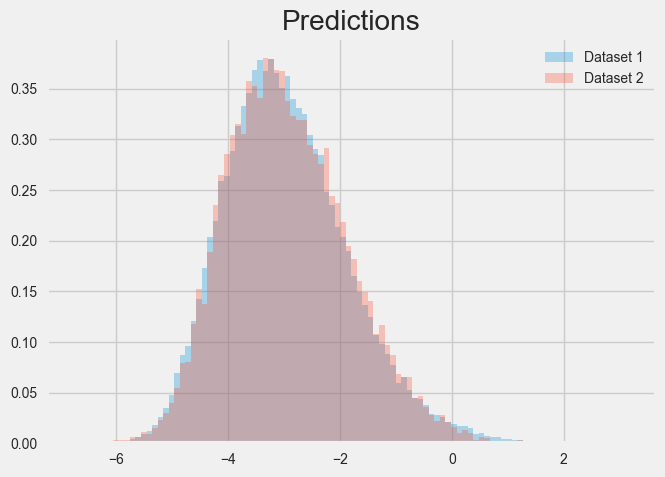

[DriftMetricsNum(mean_difference=0.016829508021836137, wasserstein=0.03731249049700174, ks_test=BaseStatisticalTestResult(statistic=0.016788888888888853, pvalue=0.01237791993896873))]

In [61]:
cinnamon.plot_prediction_drift(drift_explainer, bins=100)
drift_explainer.get_prediction_drift()

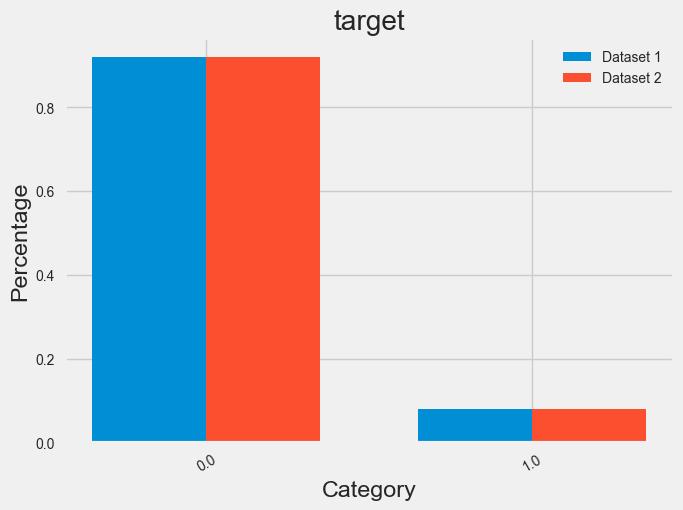

DriftMetricsCat(wasserstein=0.0005555555555555453, jensen_shannon=0.0007226819299692019, chi2_test=Chi2TestResult(statistic=0.030535805675018412, pvalue=0.8612800278806416, dof=1, contingency_table=        0.0     1.0
X1  82796.0  7204.0
X2   9194.0   806.0))

In [62]:
cinnamon.plot_target_drift(drift_explainer)
drift_explainer.get_target_drift()

In [63]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_train, clf.predict_proba(X_train))}')

log_loss test: 0.23484839576759356
log_loss prod: 0.1833899492446665


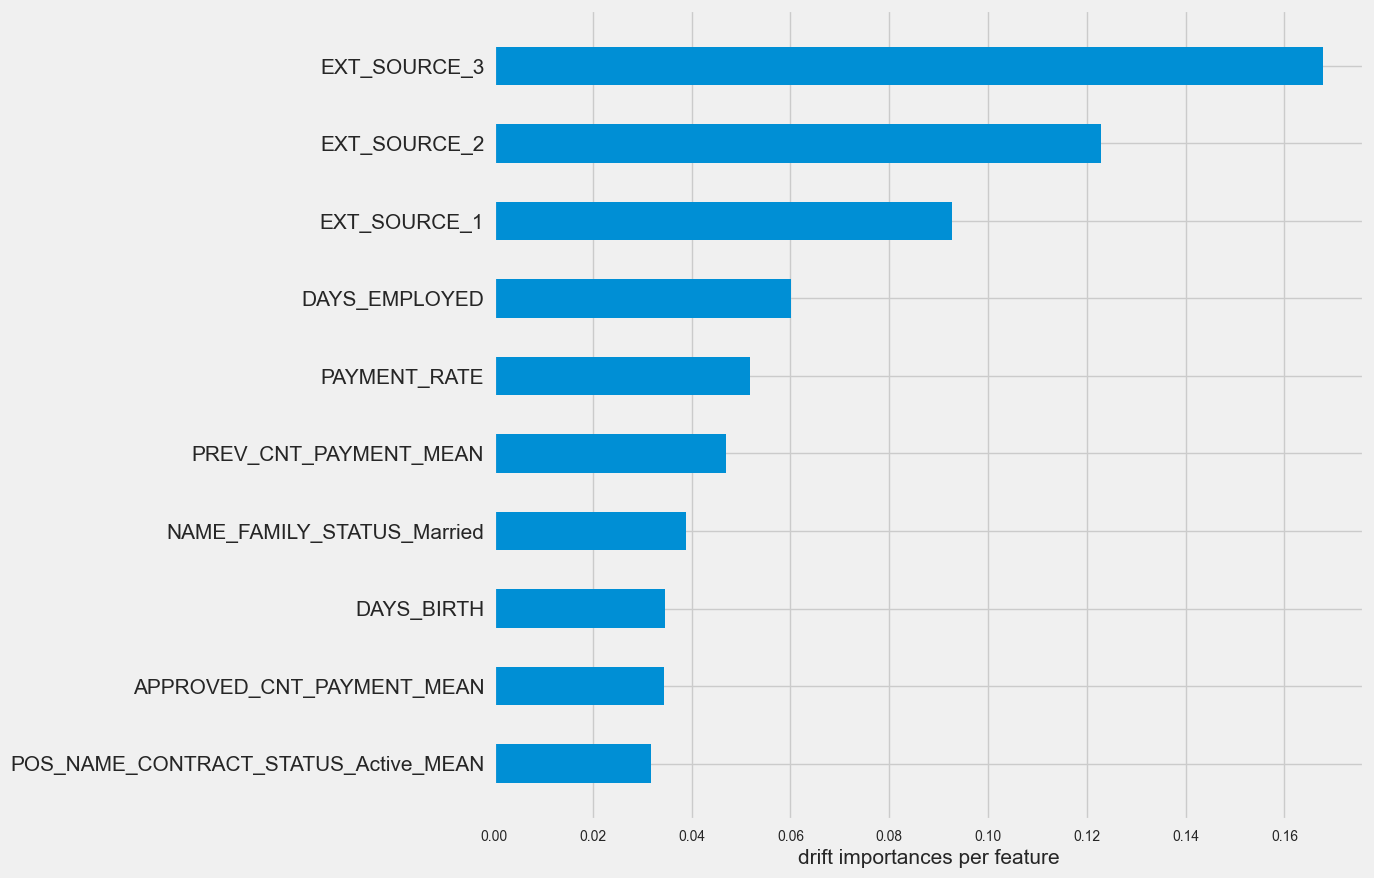

In [64]:
# plot drift importances in order to identify features that have the higher impacts on data drift
cinnamon.plot_tree_based_drift_importances(drift_explainer, type='node_size')

In [67]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    #class_names=['bad', 'good'],
    mode='classification'
)

In [69]:

exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=lgbm.predict_proba
)

exp.show_in_notebook(show_table=True)

2023/04/30 18:20:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3171f519dc704554859004ec067de145', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/04/30 18:20:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd3ae3b1a369a4ce8bebea47e4afaf792', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [71]:
!jupyter nbextension enable evidently --py --sys-prefix

Enabling notebook extension evidently/extension...
      - Validating: OK


In [73]:
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *


In [74]:
import joblib
#lgbm = joblib.load(open(os.path.join('../app/models/best_model.pkl'), 'rb'))

reference = X_train.copy()
reference['target'] = y_train.values
reference['prediction'] = lgbm.predict(X_train)
current = X_test.copy()
current['target'] = y_test.values
current['prediction'] = lgbm.predict(X_test)
current = current.sample(500, replace=False)
reference = reference.sample(500, replace=False)

In [77]:
data_stability= TestSuite(tests=[
    DataStabilityTestPreset(),
])
data_stability.run(current_data=current, reference_data=reference, column_mapping=None)
data_stability.save_html("../app/data/data_stability_report.html")

In [78]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=current, reference_data=reference, column_mapping=None)
data_drift_report.save_html("../app/data/data_drift_report.html")

In [ ]:
data_stability.show(mode='inline')